# 18. 문자를 읽을 수 있는 딥러닝
**다양한 OCR모델 비교하기**

<br><br><br>

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from glob import glob

# 1. 검증용 데이터셋 준비
텍스트의 모양과 크기, 배치, 노이즈 등 다양한 데이터 준비

In [42]:
data_dir = os.getenv('HOME')+'/aiffel/data/e18_ocr/'
img_list = glob(data_dir + '*.jpg')
img_list.sort()
img_list

['/home/ssac14/aiffel/data/e18_ocr/img0.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img1.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img2.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img3.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img4.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img5.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img6.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img7.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img8.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img9.jpg']

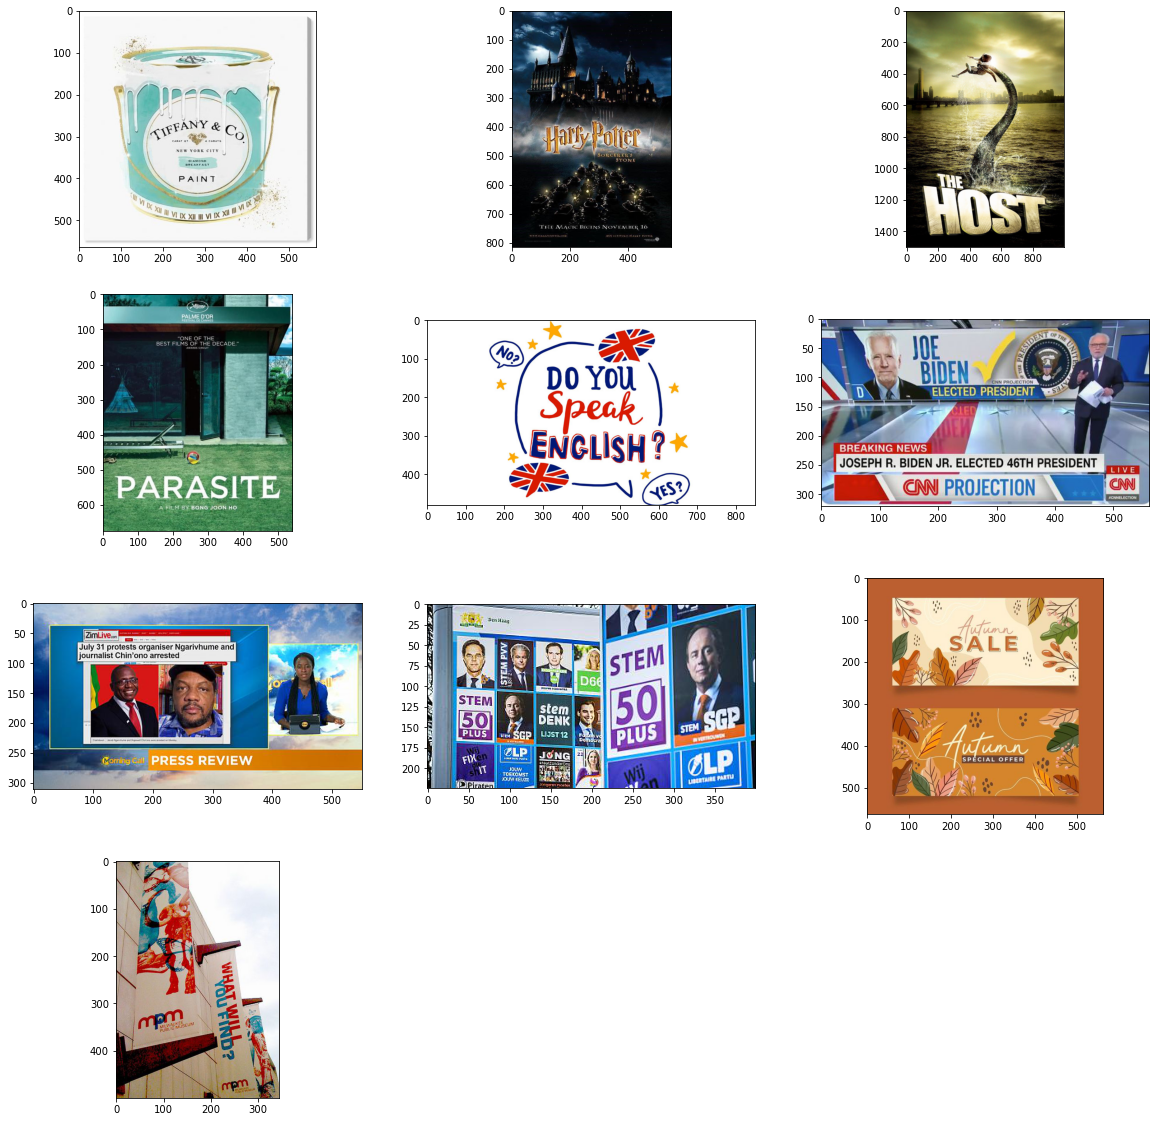

In [29]:
# 이미지 출력
plt.figure(figsize=(20, 20))
for i, im in enumerate(img_list):
    plt.subplot(4, 3, i+1)
    image = img.imread(im)
    plt.imshow(image)

<br><br><br><br>

# 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

## google OCR API

In [74]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')
    result = []
    for text in texts:
        print('\n"{}"'.format(text.description))
        result.append(text.description)

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])
    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return ' '.join(result[1:])

In [78]:
# 3번 시각화를 위한 코드 - print문 제거
def detect_text_result(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    result = []
    for text in texts:
        result.append(text.description)

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return ' '.join(result[1:])

In [34]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [33]:
for i, image in enumerate(img_list):
    print(image, '>>>>>>>>>>>>>>>>>>>>>>')
    detect_text(image)
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

/home/ssac14/aiffel/data/e18_ocr/img0.jpg >>>>>>>>>>>>>>>>>>>>>>
Texts:

"TIFFANY
&
Co.
CARAT WT.
4 CARATS
NEW YORK CITY
DIAMOND
BREAKFAST
PAINT
( VI IX XII II VI IX XII III VI IX XII III VI IX X
"

"TIFFANY"

"&"

"Co."

"CARAT"

"WT."

"4"

"CARATS"

"NEW"

"YORK"

"CITY"

"DIAMOND"

"BREAKFAST"

"PAINT"

"("

"VI"

"IX"

"XII"

"II"

"VI"

"IX"

"XII"

"III"

"VI"

"IX"

"XII"

"III"

"VI"

"IX"

"X"
bounds: (416,442),(418,441),(428,457),(426,458)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
/home/ssac14/aiffel/data/e18_ocr/img1.jpg >>>>>>>>>>>>>>>>>>>>>>
Texts:

"Hai folter
SORCERER's
STONE
THE MACIC BEGINS NOVEMBER 16
www.HAAVPOTTER.COM
AOL KEYVwORD: HAR RY POTTER
पामरम्र
"

"Hai"

"folter"

"SORCERER's"

"STONE"

"THE"

"MACIC"

"BEGINS"

"NOVEMBER"

"16"

"www.HAAVPOTTER.COM"

"AOL"

"KEYVwORD:"

"HAR"

"RY"

"POTTER"

"पामरम्र"
bounds: (187,92),(174,150),(165,147),(178,90)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
/home/ssac14/aiffel/data/e18_ocr/img2.j

## keras-ocr

In [1]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac14/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac14/.keras-ocr/crnn_kurapan.h5


In [4]:
images_keras_ocr = [keras_ocr.tools.read(image) for image in img_list]
prediction_groups = [pipeline.recognize([image]) for image in img_list]

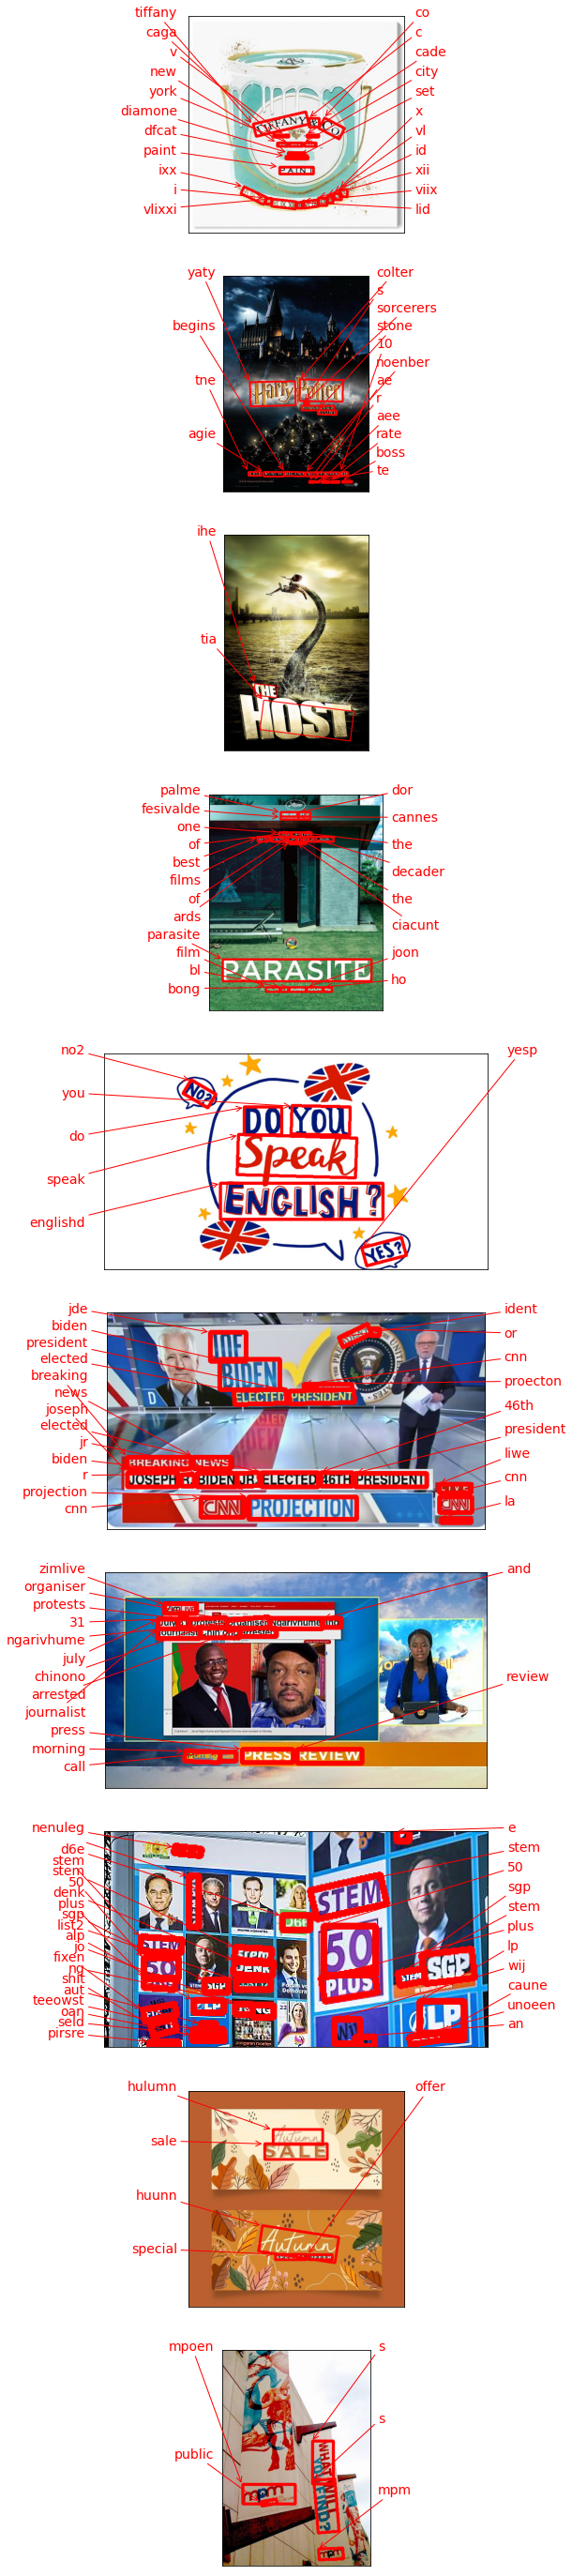

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [18]:
import pytesseract
from PIL import Image
from pytesseract import Output

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    try:
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        custom_oem_psm_config = r'--oem 3 --psm 3'
        image = Image.open(image_path)

        recognized_data = pytesseract.image_to_data(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )

        top_level = max(recognized_data['level'])
        index = 0
        cropped_image_path_list = []
        for i in range(len(recognized_data['level'])):
            level = recognized_data['level'][i]

            if level == top_level:
                left = recognized_data['left'][i]
                top = recognized_data['top'][i]
                width = recognized_data['width'][i]
                height = recognized_data['height'][i]
                output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
                cropped_image = image.crop((
                    left,
                    top,
                    left+width,
                    top+height
                ))
                cropped_image.save(output_img_path)
                cropped_image_path_list.append(output_img_path)
                index += 1
        return cropped_image_path_list
    except SystemError as e:
        print(e)

In [20]:
img_list

['/home/ssac14/aiffel/data/e18_ocr/img0.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img1.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img2.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img3.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img4.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img5.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img6.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img7.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img8.jpg',
 '/home/ssac14/aiffel/data/e18_ocr/img9.jpg']

In [21]:
work_dir = os.getenv('HOME')+'/aiffel/data/e18_ocr/output'

cropped_image_path_list = {}
for i, img in enumerate(img_list):
    dir_path = work_dir + f'/{i}'
    path_list = crop_word_regions(img, dir_path)
    cropped_image_path_list[i] = path_list

tile cannot extend outside image
tile cannot extend outside image


In [22]:
cropped_image_path_list

{0: ['/home/ssac14/aiffel/data/e18_ocr/output/0/0000.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0001.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0002.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0003.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0004.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0005.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0006.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0007.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0008.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0009.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/0/0010.png'],
 1: ['/home/ssac14/aiffel/data/e18_ocr/output/1/0000.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/1/0001.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/1/0002.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/1/0003.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/1/0004.png',
  '/home/ssac14/aiffel/data/e18_ocr/output/1/0005.png',
  '/home/ssac14/aiffel/data/e18_ocr/outpu

In [29]:
def recognize_images(i, cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>{i}>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print()

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for key, value in cropped_image_path_list.items():
    if value:
        recognize_images(key, value)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>0>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 ia NEW YORK Suey, FE yr ge  yy 23 a wee aaa mmm ee UL 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
aa THE MA AcIc B hc LINAS INNOWV = ek Ae Lee cs eageitone 7 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
: A 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 “ON - CF | HE sj nie le HE DECADE.” a : ’ 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 i, XS (3 You \ ENGLISH ?  ye s a 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
> 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 | x_n ge ae | { | : , a | sald | A | July 37 protests VIQAINSer Ngarivhume and journalist Chin’on oO arresteq 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>7>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
a 



In [101]:
# 3번 시각화용 print문 제거
def recognize_images_result(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)

<br><br><br><br>

# 3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요

In [107]:
import time

plt.figure(figsize=(50, 50))
for i, im in enumerate(img_list):
    print(f'{i}번째 이미지 결과 >>>>>>>>')
#     plt.subplot(10, 1, i+1)
#     image = img.imread(im)
#     plt.imshow(image)
#     time.sleep(3)
    print('<Google OCR API>')
    print(detect_text_result(im))
    print('<keras-ocr>')
    keras_ocr_result = [txt[0] for txt in prediction_groups[i][0]]
    keras_ocr_result = ' '.join(keras_ocr_result)
    print(keras_ocr_result)
    print('<Tesseract>')
    if cropped_image_path_list[i]:
        recognize_images_result(cropped_image_path_list[i])
    print()

0번째 이미지 결과 >>>>>>>>
<Google OCR API>
TIFFANY & Co. CARAT WT. 4 CARATS NEW YORK CITY DIAMOND BREAKFAST PAINT ( VI IX XII II VI IX XII III VI IX XII III VI IX X
<keras-ocr>
tiffany c co caga v cade new york city diamone dfcat set paint ixx x vl id i xii vlixxi viix lid
<Tesseract>
 ia NEW YORK Suey, FE yr ge  yy 23 a wee aaa mmm ee UL 

1번째 이미지 결과 >>>>>>>>
<Google OCR API>
Hai folter SORCERER's STONE THE MACIC BEGINS NOVEMBER 16 www.HAAVPOTTER.COM AOL KEYVwORD: HAR RY POTTER पामरम्र
<keras-ocr>
colter yaty s sorcerers stone tne agie begins 10 noenber ae r aee rate boss te
<Tesseract>
aa THE MA AcIc B hc LINAS INNOWV = ek Ae Lee cs eageitone 7 

2번째 이미지 결과 >>>>>>>>
<Google OCR API>
THE HOST
<keras-ocr>
ihe tia
<Tesseract>
: A 

3번째 이미지 결과 >>>>>>>>
<Google OCR API>
PALME D'OR FESTIVAL DE CANNES "ONE OF THE BEST FILMS OF THE DECADE." AWARDS CIRCUIT PARASITE A FILM BY BONG JOON HO
<keras-ocr>
palme dor fesivalde cannes one of the best decader films of the ards ciacunt parasite film bl bong j

<Figure size 3600x3600 with 0 Axes>

<br><br><br><br>

# 4. 결과 분석과 결론 제시

### 서비스
시각장애인을 위한 텍스트 인식 후 음성으로 번역해주는 서비스

### 평가 기준
- 다양한 제품의 텍스트 인식을 위해 텍스트 변형에도 텍스트 영역 검출이 잘 되어야 한다.
- 검출 후 문자를 잘 읽어내야 한다.


### 결과 분석
- Google OCR API
  - 텍스트의 변형, 노이즈, 필기체, 다양한 크기에도 잘 읽어낸다.
  - 이 서비스에는 크게 관련은 없지만, 추가적으로 대소문자를 구분해낸다.
  
- keras ocr
  - 텍스트 변형에 약간 민감하다.
  - 기호에 대한 학습이 없었던건지 기호는 읽어내지 못한다.
- Tesseract
  - 텍스트의 크기, 노이즈, 변형 등 다양한 변형에 대부분 대응해내지 못했다.
  
### 결론
**Google OCR API**  
육안으로도 확인하기 힘든 노이즈가 많이 끼고 작은 글씨에도 제대로 읽어내는 것을 보면 정확한 정보를 전달해야 하는 시각장애인에게는 이 부분에 탁월한 성능을 보이는 google ocr api가 적절하다고 판단된다. 아직 세로로 된 글자 인식에는 미흡한 부분을 보이기는 한다.

<br><br><br><br>

## 회고
이미지 내에 텍스트들이 여러 부분 분포되어 있어 모델이 텍스트 구조를 분석하고 인식하는 과정에서 다양한 오차가 발생할 수 있다고 한다. 이런 부분을 해결하기 위해 이미지에서 특정 텍스트 부분만 잘라내어 별도로 텍스트 추출을 진행하면 좀 더 개선된다고 한다.